## Quick script to collect X amount of events, collect 2D hist data from them, then delete the data in memory and keep going.

This is the only way to get the full high pressure plots without everything breaking

In [2]:
import sys,os,os.path


# NOTE, IF YOU'RE MOVING THIS AROUND IN DIRECTORIES, NEED TO CHANGE BELOW LINE
sys.path.append("../../")   # cite IC from parent directory
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from   IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

In [3]:
#adding here ROI
emin = 1.5
emax = 1.7

# chunking, how many splits of the data you're going to make
# generally I'd recommend you do this after you know exactly how many files you have
chunking = 120


# collect files
folder_path = '../LPR/208Tl/PORT_1a/prod/isaura/isaura/'


# collect all file_names
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
print("Number of files: {}\nSplitting up into chunks of {}".format(len(file_names), chunking))

Number of files: 300
Splitting up into chunks of 120


In [4]:
# function that outputs the 2D hist properties
def collect_2dhist_props(df, binning = (50,10)):
    h, xedges, yedges, img = plt.hist2d(df.energy, df.numb_of_tracks, bins=binning, cmin=0.001, range=[[0, 3], [0, 12]])
    return (h, xedges, yedges)

100
200
300


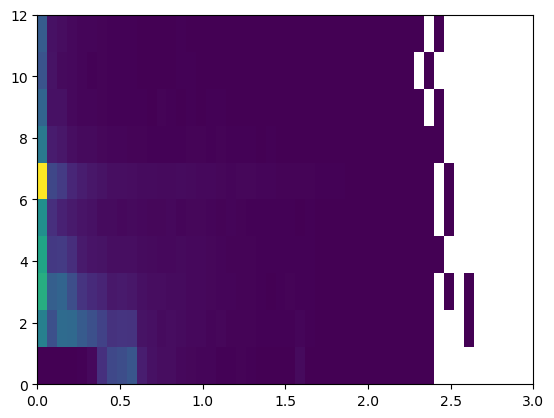

In [5]:
# NOTE Break this section up, its annoying like this.
dfs = []
hold_data = []
i = 0
end = len(file_names)
# create massive dataframe with all tracks
for file in file_names:
    file_path = folder_path + file
    df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
    dfs.append(df)

    i += 1

    # collect the relevant data, then delete the dataframe before it gets too big
    if (i%round(end/10)== 0):
        print("Collecting 2dhistogram data")
        dfs = pd.concat(dfs, axis=0, ignore_index=True)
        hold_data.append(collect_2dhist_props(dfs))
        dfs = []


    if (i%100 == 0):
        print(i)

# then collect the data that made it out of the loop
if (len(dfs) != 0):
    dfs = pd.concat(dfs, axis=0, ignore_index=True)
    hold_data.append([collect_2dhist_props(dfs)])
    dfs = []

In [6]:
# collate data
h_total = np.zeros((50,10))
for i in range(len(hold_data)):
    h_total = h_total + hold_data[i][0]

print(h_total)



[[       nan 9.3740e+03 1.3874e+04 1.2617e+04 1.1128e+04 1.9704e+04
  8.5070e+03 6.6280e+03 5.5180e+03 6.6310e+03]
 [       nan 4.9710e+03 5.9600e+03 4.0540e+03 2.7470e+03 4.2060e+03
  1.6060e+03 1.1350e+03 8.9900e+02 1.0020e+03]
 [       nan 7.2200e+03 6.6970e+03 3.6640e+03 2.2290e+03 3.1380e+03
  1.1800e+03 7.9600e+02 6.2300e+02 6.9900e+02]
 [3.7000e+01 7.1380e+03 4.8020e+03 2.3810e+03 1.5660e+03 2.1200e+03
  7.6900e+02 5.5200e+02 4.2600e+02 4.9100e+02]
 [1.2400e+02 5.9020e+03 3.2680e+03 1.5890e+03 1.0320e+03 1.5170e+03
  5.5000e+02 3.6400e+02 3.2200e+02 3.4300e+02]
 [4.1700e+02 5.0450e+03 2.4940e+03 1.2220e+03 8.0700e+02 1.1430e+03
  4.4700e+02 3.0700e+02 2.2100e+02 2.4600e+02]
 [3.0940e+03 4.4150e+03 2.0620e+03 9.7100e+02 6.5900e+02 9.3500e+02
  3.5600e+02 2.2900e+02 1.6900e+02 1.9400e+02]
 [5.0480e+03 3.1920e+03 1.3990e+03 7.6800e+02 5.3400e+02 7.8200e+02
  2.8600e+02 1.7900e+02 1.4500e+02 1.4300e+02]
 [5.1080e+03 3.1210e+03 1.4250e+03 7.8400e+02 5.4600e+02 7.6600e+02
  2.2700e+02

In [7]:
# collect edges
x_edges = hold_data[0][1]
y_edges = hold_data[0][2]
print(x_edges, y_edges)

[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.66 0.72 0.78
 0.84 0.9  0.96 1.02 1.08 1.14 1.2  1.26 1.32 1.38 1.44 1.5  1.56 1.62
 1.68 1.74 1.8  1.86 1.92 1.98 2.04 2.1  2.16 2.22 2.28 2.34 2.4  2.46
 2.52 2.58 2.64 2.7  2.76 2.82 2.88 2.94 3.  ] [ 0.   1.2  2.4  3.6  4.8  6.   7.2  8.4  9.6 10.8 12. ]


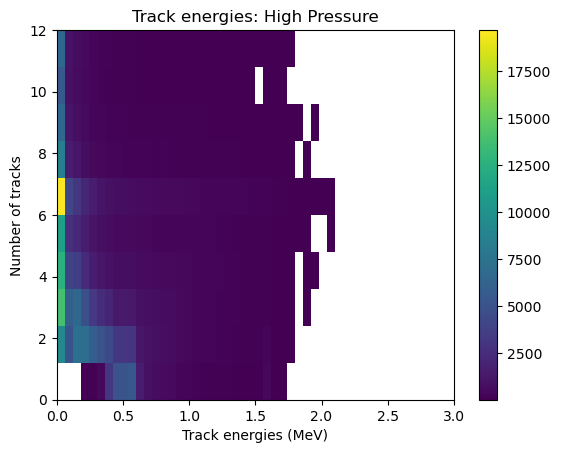

In [8]:
# print data

# NOTE, need to transpose the data to get the correct format (lol)
plt.imshow(h_total.T, extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], origin='lower', cmap='viridis', aspect = 'auto')
plt.colorbar()
plt.title("Track energies: High Pressure")
plt.xlabel("Track energies (MeV)")
plt.ylabel("Number of tracks")
plt.show()

### Sanity check, plot a chunk of the data here to make sure you're not accidentally including some background or something strange

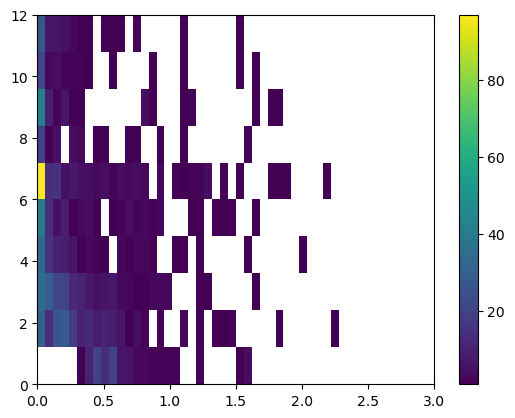

In [9]:
dfs = []
mcs = []
df_ems = []


'''
for file in file_names:
    file_path = folder_path + file
    df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
    dfs.append(df)

    mc = pd.read_hdf(file_path, 'MC/particles')
    mcs.append(mc)
    df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
    df_ems.append(df_em)

mcs = pd.concat(mcs, axis=0, ignore_index=True)
dfs = pd.concat(dfs, axis=0, ignore_index=True)
em = pd.concat([dt for dt in df_ems])
'''
# just for now, source from one beersheba file
file = 'isaura_53_208Tl.h5'
dfs = dstio.load_dst(folder_path + file, 'Tracking', 'Tracks')
mcs = pd.read_hdf(folder_path + file, 'MC/particles')
em = mcio.load_eventnumbermap(folder_path + file).set_index('nexus_evt')

plt.hist2d(dfs.energy, dfs.numb_of_tracks, bins=(50,10), cmin=0.001, range=[[0, 3], [0, 12]])
plt.colorbar()


#### so many events with 0.5 MeV with one track, lets find one!

In [10]:
soph_500keV_events = dfs[dfs.numb_of_tracks == 1]
display(soph_500keV_events)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,1040000,0,0.687589,51.052365,45,5419,1,-57.325,262.675,469.894379,...,481.621988,-47.523449,269.975309,476.830750,0.395317,0.224727,0.000000,9.333333,10.000000,4.706886
3,1040004,0,0.946256,71.808832,77,3918,1,259.675,347.675,502.424774,...,504.353261,311.488236,365.561228,528.417459,0.772430,0.018339,0.000000,8.714286,8.500000,4.619238
6,1040008,0,0.419748,27.419458,19,2451,1,128.675,204.675,121.314629,...,137.811894,148.498790,224.341987,123.576265,0.387212,0.224645,0.192109,8.500000,8.250000,4.955450
33,1040024,0,0.652844,35.603489,38,4417,1,376.675,76.675,767.051880,...,779.852561,409.579195,101.136176,776.485003,0.420104,0.324756,0.095193,9.200000,9.000000,4.184741
34,1040026,0,0.539859,36.268564,29,3743,1,102.675,183.675,466.719360,...,483.512507,108.346054,189.883635,468.612309,0.399209,0.236572,0.095922,8.333333,10.000000,4.970840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,1040676,0,0.706134,50.821877,56,3768,1,170.675,-44.325,1163.954346,...,1175.464966,171.608091,-31.955459,1186.312666,0.292653,0.211951,0.000000,9.125000,8.250000,4.716858
1035,1040684,0,0.417024,23.264890,16,2343,1,189.675,128.675,582.254272,...,585.455593,194.728350,140.557626,598.625153,0.409646,0.405272,0.397895,8.000000,8.666667,4.703949
1039,1040688,0,0.587537,54.940271,41,3196,1,378.675,71.675,500.334930,...,503.167937,414.938323,113.094866,522.956540,0.446493,0.140799,0.000000,8.400000,9.600000,4.188136
1040,1040690,0,0.583100,31.462258,31,3137,1,-164.325,20.675,814.282959,...,827.701607,-134.267995,33.594460,818.250013,0.456325,0.322699,0.200389,8.600000,8.750000,4.607947


In [11]:
def energy_cuts(df, lower_e = 1.5, upper_e = 1.7, verbose = False):
    '''
    Apply cuts around the relevant energy
    '''
    filt_e_df = df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)]

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return filt_e_df

# cut between 0.4 and 0.6

soph_500keV_events = energy_cuts(soph_500keV_events, lower_e = 0.4, upper_e = 0.6)

(array([5., 5., 2., 5., 2., 3., 5., 2., 2., 0., 2., 5., 1., 2., 2., 3., 1.,
        1., 6., 8.]),
 array([0.40201878, 0.41159655, 0.42117433, 0.43075211, 0.44032988,
        0.44990766, 0.45948543, 0.46906321, 0.47864098, 0.48821876,
        0.49779653, 0.50737431, 0.51695208, 0.52652986, 0.53610763,
        0.54568541, 0.55526318, 0.56484096, 0.57441873, 0.58399651,
        0.59357429]),
 <BarContainer object of 20 artists>)

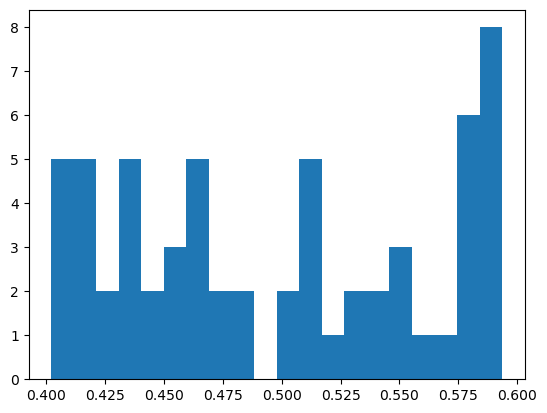

In [12]:
# double checking, this is exclusively events in this 0.4 - 0.6 bin window
plt.hist(soph_500keV_events.energy, bins = 20)

In [13]:
# take first 20 events to study
display(soph_500keV_events.head(20))

# how many events total?
print("{}/{} events in 0.4 - 0.6 MeV region".format(len(soph_500keV_events),len(dfs)))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
6,1040008,0,0.419748,27.419458,19,2451,1,128.675,204.675,121.314629,...,137.811894,148.498790,224.341987,123.576265,0.387212,0.224645,0.192109,8.500000,8.250000,4.955450
34,1040026,0,0.539859,36.268564,29,3743,1,102.675,183.675,466.719360,...,483.512507,108.346054,189.883635,468.612309,0.399209,0.236572,0.095922,8.333333,10.000000,4.970840
81,1040060,0,0.582688,48.925316,52,3946,1,293.675,85.675,69.933968,...,72.502769,303.973294,114.742536,98.612096,0.338482,0.225419,0.001285,8.000000,9.166667,4.322439
85,1040064,0,0.514372,55.057272,61,5103,1,322.675,122.675,326.056427,...,333.868664,341.788176,172.878189,328.712568,0.273472,0.130293,0.000000,8.750000,9.500000,4.391235
112,1040078,0,0.458801,37.023542,29,2751,1,360.675,37.675,839.486206,...,857.461190,378.614278,76.533985,840.498643,0.339134,0.148742,0.029075,9.000000,8.833333,4.186157
149,1040106,0,0.456476,54.944914,40,2302,1,-326.325,95.675,455.166870,...,488.559157,-312.783166,116.862964,455.166870,0.398024,0.056039,0.001317,8.666667,8.333333,4.845047
161,1040114,0,0.407417,19.127795,10,1874,1,394.675,121.675,422.638489,...,425.431621,404.355310,126.830752,433.302570,0.406993,0.401028,0.400604,9.750000,8.600000,4.184273
195,1040130,0,0.593574,41.915914,40,3490,1,204.675,344.675,529.765564,...,532.356113,235.938802,358.391420,555.271417,0.482767,0.196128,0.085716,9.750000,8.000000,4.713562
231,1040164,0,0.410331,32.354971,25,2516,1,345.675,-14.325,592.737305,...,604.475538,352.863543,15.519914,594.279324,0.345450,0.201883,0.137002,8.750000,9.000000,4.446243
253,1040180,0,0.483504,34.752492,29,2453,1,345.675,-317.325,1023.227234,...,1037.398363,364.422994,-285.318073,1023.227234,0.439499,0.159526,0.120263,9.800000,9.500000,4.976761


62/1066 events in 0.4 - 0.6 MeV region


In [14]:
display(mcs)
display(em)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,520000,1,Tl208,True,0,396.394226,399.282104,532.892334,0.000000,396.394226,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,520000,4,e-,False,1,396.394226,399.282104,532.892334,0.000383,393.230042,...,0.442017,-0.898381,-0.067551,-0.000000,-0.0000,0.000000,0.615123,15.324601,RadioactiveDecay,eIoni
2,520000,3,anti_nu_e,False,1,396.394226,399.282104,532.892334,0.000383,-4166.637695,...,-0.199757,0.376400,0.523887,-0.199757,0.3764,0.523887,0.675305,15425.949219,RadioactiveDecay,Transportation
3,520000,2,Pb208[3708.451],False,1,396.394226,399.282104,532.892334,0.000383,396.394226,...,-0.242260,0.521981,-0.456337,-0.000000,0.0000,-0.000000,0.000001,0.000000,RadioactiveDecay,RadioactiveDecay
4,520000,6,gamma,False,2,396.394226,399.282104,532.892334,0.000383,407.814026,...,0.388040,0.147194,-0.297680,-0.000000,-0.0000,-0.000000,0.510739,46.717052,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27781,520352,33,e-,False,21,264.843567,313.633148,370.056244,1.290199,264.308441,...,0.023639,-0.156730,0.160504,-0.000000,-0.0000,-0.000000,0.047575,3.272024,eIoni,eIoni
27782,520352,32,e-,False,21,231.945099,307.978149,369.958435,0.999002,233.183533,...,-0.034773,0.313250,-0.436327,0.000000,0.0000,0.000000,0.231184,36.112244,eIoni,eIoni
27783,520352,47,e-,False,32,229.955933,309.552856,367.327667,1.016094,230.011826,...,0.030967,0.096428,-0.093226,-0.000000,-0.0000,-0.000000,0.018216,0.808527,eIoni,eIoni
27784,520352,31,e-,False,21,269.094879,382.380005,468.973846,0.491798,269.017029,...,-0.072428,0.128760,-0.016591,0.000000,-0.0000,0.000000,0.021185,0.863515,eIoni,eIoni


,evt_number
nexus_evt,
520000,1040000
520001,1040002
520002,1040004
520003,1040006
520004,1040008
...,...
520348,1040696
520349,1040698
520350,1040700


In [15]:
display(mcs[mcs.event_id == 520351])

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
27685,520351,1,Tl208,True,0,395.837708,394.306458,531.602783,0.000000,395.837708,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,none,RadioactiveDecay
27686,520351,4,e-,False,1,395.837708,394.306458,531.602783,0.001011,395.129944,...,-0.938544,-0.350963,0.022973,-0.000000,-0.000000,0.000000,6.140286e-01,1.254776e+00,RadioactiveDecay,eIoni
27687,520351,3,anti_nu_e,False,1,395.837708,394.306458,531.602783,0.001011,-12039.825195,...,-0.848185,0.153268,0.816315,-0.848185,0.153268,0.816315,1.187130e+00,1.740511e+04,RadioactiveDecay,Transportation
27688,520351,2,Pb208[3197.711],False,1,395.837708,394.306458,531.602783,0.001011,395.837708,...,1.786727,0.197696,-0.839286,0.000000,0.000000,-0.000000,1.016021e-05,0.000000e+00,RadioactiveDecay,RadioactiveDecay
27689,520351,6,gamma,False,2,395.837708,394.306458,531.602783,0.001011,171.258072,...,-0.439760,-0.232480,-0.304422,0.000000,0.000000,0.000000,5.831881e-01,1.247716e+03,RadioactiveDecay,phot
27690,520351,25,e-,False,6,171.258072,528.819092,496.746094,4.162945,171.258072,...,0.005896,-0.002532,0.004526,0.000000,-0.000000,0.000000,6.032000e-05,1.470291e-07,phot,msc
27691,520351,24,e-,False,6,171.258072,528.819092,496.746094,4.162945,171.258072,...,-0.004144,-0.003752,0.000626,-0.000000,-0.000000,0.000000,3.096000e-05,1.181998e-07,phot,msc
27692,520351,23,e-,False,6,171.258072,528.819092,496.746094,4.162945,171.258072,...,0.002721,-0.003860,-0.006324,0.000000,-0.000000,-0.000000,6.095000e-05,1.476343e-07,phot,msc
27693,520351,22,e-,False,6,171.258072,528.819092,496.746094,4.162945,171.258072,...,-0.017455,-0.007338,0.021594,0.000000,-0.000000,0.000000,8.064300e-04,1.387589e-05,phot,eIoni
27694,520351,21,e-,False,6,171.258072,528.819092,496.746094,4.162945,171.258072,...,0.028514,0.007030,-0.002550,0.000000,0.000000,-0.000000,8.495400e-04,1.521998e-05,phot,eIoni
